# Intro

The project is to create "Monet like" paintings using a GAN model. We are given 300 monet paintings and 7000 photos to work with in the initial dataset, the goal is to have a GAN that generates between 7000-10000 images and they must be sized 256x256.  

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *

In [97]:
for dirname, _, filenames in os.walk('Downloads/gan-getting-started'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Downloads/gan-getting-started\monet_jpg\000c1e3bff.jpg
Downloads/gan-getting-started\monet_jpg\011835cfbf.jpg
Downloads/gan-getting-started\monet_jpg\0260d15306.jpg
Downloads/gan-getting-started\monet_jpg\049e293b93.jpg
Downloads/gan-getting-started\monet_jpg\05144e306f.jpg
Downloads/gan-getting-started\monet_jpg\052a77c020.jpg
Downloads/gan-getting-started\monet_jpg\058f878b7c.jpg
Downloads/gan-getting-started\monet_jpg\05b493ff42.jpg
Downloads/gan-getting-started\monet_jpg\064487d630.jpg
Downloads/gan-getting-started\monet_jpg\066fe4cbaa.jpg
Downloads/gan-getting-started\monet_jpg\07fcaee35f.jpg
Downloads/gan-getting-started\monet_jpg\09b76b6471.jpg
Downloads/gan-getting-started\monet_jpg\0a5075d42a.jpg
Downloads/gan-getting-started\monet_jpg\0bd913dbc7.jpg
Downloads/gan-getting-started\monet_jpg\0e3b3292da.jpg
Downloads/gan-getting-started\monet_jpg\106757e5d8.jpg
Downloads/gan-getting-started\monet_jpg\1078363ff0.jpg
Downloads/gan-getting-started\monet_jpg\10c555c1b1.jpg
Downloads/

# Initial Data

The first blocks in this notebook are used to read in packages, read in the data, transform the data, and make sure that everything is operating smoothly. After making sure that everything works properly when it comes to reading in the data we can move onto the models that will be needed.  

In [98]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [99]:
m_files= tf.io.gfile.glob(str('Downloads/gan-getting-started' + '/monet_tfrec/*.tfrec'))
p_files= tf.io.gfile.glob(str('Downloads/gan-getting-started' + '/photo_tfrec/*.tfrec'))

In [100]:
print('No. of Monet TFRecord files: ',len(m_files))
print('No. of Photo TFRecord files: ',len(p_files))

No. of Monet TFRecord files:  5
No. of Photo TFRecord files:  20


In [101]:
IMAGE_SIZE= [256,256]                                            # required size of image

def decode_img(image):                                           # function for decoding the image present in jpeg format
    image= tf.image.decode_jpeg(image,channels= 3)               # 3 channels because of RGB
    image= (tf.cast(image, tf.float32)/255)*2 -1                 # converting the pixel values in range [-1,1]
    image= tf.reshape(image, shape= [*IMAGE_SIZE,3])             # reshaping the image to proper size
    return image

def read_tfrec(example):                                         # function for extracting image from TFRecord format
    tfrec_format= {
        'image_name': tf.io.FixedLenFeature([], tf.string),      
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example= tf.io.parse_single_example(example, tfrec_format)
    image= decode_img(example['image'])
    return image

In [102]:
def load_data(files):
    data= tf.data.TFRecordDataset(files)
    data= data.map(read_tfrec)                                  
    return data

In [103]:
m_data= load_data(m_files).batch(1)                      # forming batches of size=1 (i.e. 1 image processed at a time)
p_data= load_data(p_files).batch(1)

In [104]:
next_monet= iter(m_data)
next_photo= iter(p_data)

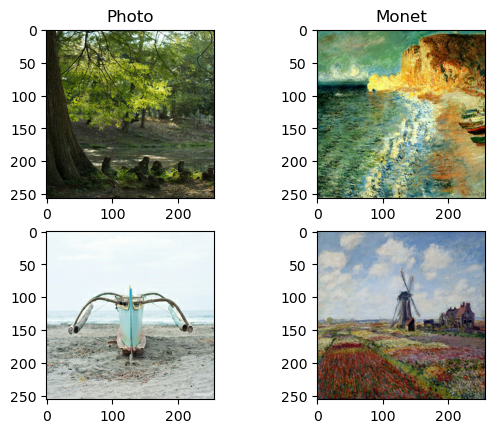

In [106]:
plt.subplot(2,2,1)                                    
plt.title('Photo')
plt.imshow(next(next_photo)[0]*0.5 +0.5)

plt.subplot(2,2,3)                                    
plt.imshow(next(next_photo)[0]*0.5 +0.5)

plt.subplot(2,2,2)
plt.title('Monet')
plt.imshow(next(next_monet)[0]*0.5 +0.5)

plt.subplot(2,2,4)
plt.imshow(next(next_monet)[0]*0.5 +0.5)     

# Model

After reading in the data and transforming it to fit the specifications (256x256) we can finally start building the model. To do that we need to make a generator and a discriminator for our GAN model. Below are downsample and upsample functions to extract/locate features and these will be used in the generator and discriminator. It would be possible to make it all one code block, but fairly painful.

In [107]:
def downsample(filters, size, instance_norm= True):                                   # for extracting important features (size is reduced)
    initializer= tf.random_normal_initializer(0,0.03)                                 # mean=0 and standard deviation=0.03 for initializing kernel weights
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.03)
    
    model= keras.Sequential()                                          
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))
    
    if instance_norm:
         model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))     # groups= -1 to make it work like Instance Normalization
   
    model.add(LeakyReLU())
    
    return model

In [108]:
def upsample(filters, size, dropout= False):                                         # for locating features accurately using skip connections 
    initializer= tf.random_normal_initializer(0,0.03)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.03)
    
    model= keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides= 2, padding= 'same', kernel_initializer= initializer, use_bias= False))
    model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))
    
    if dropout:
        model.add(Dropout(0.65))
    
    model.add(ReLU())
    
    return model

In [109]:
def generator():
    down_stack= [
        downsample(64,4,False),                 # size= (128,128,64)  (size denotes the dimensions of image after the corresponding layer/operation)
        downsample(128,4),                      # size= (64,64,128)
        downsample(256,4),                      # size= (32,32,256)
        downsample(512,4),                      # size= (16,16,512)
        downsample(512,4),                      # size= (8,8,512)
        downsample(512,4),                      # size= (4,4,512)
        downsample(512,4),                      # size= (2,2,512)
        downsample(512,4),                      # size= (1,1,512)
    ]
    
    up_stack= [
        upsample(512,4,True),                   # size= (2,2,1024)  (no. of channels doubled because upsample block concats output of last downsample block)    
        upsample(512,4,True),                   # size= (4,4,1024)
        upsample(512,4,True),                   # size= (8,8,1024)
        upsample(512,4),                        # size= (16,16,1024)  (dropout= false so that information is maintained for generating detailed outputs)
        upsample(256,4),                        # size= (32,32,512)
        upsample(128,4),                        # size= (64,64,256)
        upsample(64,4)                          # size= (128,128,128)
    ]
    
    initializer= tf.random_normal_initializer(0,0.03)
    last_layer= Conv2DTranspose(3, 4, strides= 2, padding= 'same', kernel_initializer= initializer, activation= 'tanh')     # 3 output channels required
    
    i= Input(shape= [256,256,3])                # input layer
    x= i
    skips= []
    for down in down_stack:                     # downsampling
        x= down (x) 
        skips.append(x)                         # appending skip connections to the 'skips' list
        
    skips= reversed(skips[:-1])                 # last skip connection is not used because of alignment with upsampling path
    
    for up, skip in zip(up_stack,skips):        # upsampling and concatenating output with skip connection
        x= up (x)
        x= Concatenate() ([x,skip])
        
    x= last_layer(x)                            # last layer (Conv2DTranspose) for generating the final output 
    
    model= Model(i,x)
    
    return model

In [110]:
def discriminator():
    i= Input(shape= [256,256,3])
    x= downsample(64,4) (i)                                 # size= (128,128,64) 
    x= downsample(128,4) (x)                                # size= (64,64,128) 
    x= downsample(256,4) (x)                                # size= (32,32,256)
    
    x= ZeroPadding2D() (x)                                  # size= (34,34,256)    (1 pixel padding is added at top,bottom,left,right) 
    
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    x= Conv2D(512, 4, strides= 1, padding= 'same', kernel_initializer= initializer, use_bias= False) (x) 
    x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)
    x= LeakyReLU() (x)
    
    x= ZeroPadding2D() (x)                                  # size= (33,33,512)    (zero padding applied to maintain spatial information)
    
    x= Conv2D(1, 4, strides= 1, padding= 'same', kernel_initializer= initializer) (x)       # size= (30,30,1) 
                                                                                            # sigmoid not used to output unbounded logits
    model= Model(i,x)                                                                       # (more numerically stable during training)
    
    return model

In [111]:
with strategy.scope():
    m_gen= generator()                     
    m_disc= discriminator()             
    p_gen= generator()                    
    p_disc= discriminator()            

# Model so far

The generator and discriminator have been built, but we still need to build the GAN and actually fit the data into the generator. If we try to see our generated images we get the below picture.

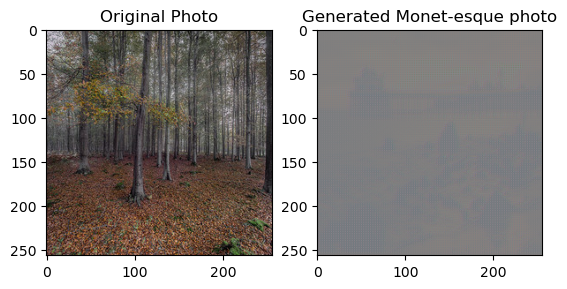

In [112]:
photo_to_monet= m_gen(next(next_photo))                # won't generate monet-esque photos as we have not fit the data into generator yet

plt.subplot(1,2,1)                                       
plt.title('Original Photo')
plt.imshow(next(next_photo)[0]*0.5 +0.5)                         

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)       

# Creating the GAN

For the most part, this is using the Keras.io format for a CycleGAN with renamed variables to fit the monet/photo project. The purpose of a CycleGAN is to learn the mapping between an input image and an output image using a training set of aligned pairs. It does this by using cycle-consistent adversarial networks. 

In [140]:
class CycleGAN(keras.Model):                       # CycleGAN class inheriting from keras.Model class so that it can use its methods to train, compile etc.
    def __init__(                                  # arguments to be passed in a CycleGAN class object   
        self,
        mo_gen,
        mo_disc,
        ph_gen,
        ph_disc,
        lambda_cycle= 10                           # 'lambda_cycle' controls the importance of cycle consistency loss
    ):
        super(CycleGAN,self).__init__()            # calls the constructor of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen= mo_gen                      # assigning argument values to attributes of a CycleGAN class object/instance
        self.m_disc= mo_disc
        self.p_gen= ph_gen
        self.p_disc= ph_disc
        self.lambda_cycle= lambda_cycle
        
    def compile(                                   
        self,
        m_gen_optimizer,
        m_disc_optimizer,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_function,
        disc_loss_function,
        cycle_loss_function,
        identity_loss_function
    ):
        super(CycleGAN,self).compile()             # calls the 'compile' fn of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self,batch_data):                                
        real_monet, real_photo= batch_data
        
        with tf.GradientTape(persistent= True) as tape:             # to keep a track of operations
            
            fake_monet= self.m_gen(real_photo, training= True)      # photo to monet and back to photo
            cycled_photo= self.p_gen(fake_monet, training= True)
            
            fake_photo= self.p_gen(real_monet, training= True)      # monet to photo and back to monet
            cycled_monet= self.m_gen(fake_photo, training= True)
            
            same_photo= self.p_gen(real_photo, training= True)      # generating itself (useful in calculating identity loss)
            same_monet= self.m_gen(real_monet, training= True)      
            
            disc_real_photo= self.p_disc(real_photo, training= True)   # discriminator used to check with real images
            disc_real_monet= self.m_disc(real_monet, training= True)   
            
            disc_fake_photo= self.p_disc(fake_photo, training= True)   # discriminator used to check with fake images
            disc_fake_monet= self.m_disc(fake_monet, training= True)
            
            gen_monet_loss= self.gen_loss_function(disc_fake_monet)    # generator loss
            gen_photo_loss= self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +     # total cycle consistency loss
            self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss= (gen_monet_loss + total_cycle_loss   +                                    # total generator monet loss
            self.identity_loss_function(real_monet, same_monet, self.lambda_cycle) )  
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss   +                                    # total generator photo loss
            self.identity_loss_function(real_photo, same_photo, self.lambda_cycle) )
            
            disc_monet_loss= self.disc_loss_function(disc_real_monet, disc_fake_monet)                      # discriminator monet loss 
            disc_photo_loss= self.disc_loss_function(disc_real_photo, disc_fake_photo)                      # discriminator photo loss
            
            
        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)            # calculate gradients for generators
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)            # diff loss fn wrt trainable variables of model
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               # calculate gradients for discriminators
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      # apply the gradients to optimizer
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))      # basically performing gradient descent
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

In [141]:
with strategy.scope():
    def gen_loss_fn(generated):           
        return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [142]:
with strategy.scope():
    def disc_loss_fn(real, generated):
        loss_real= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
        loss_fake= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
        total_loss= (loss_real + loss_fake)/2
        
        return total_loss

In [143]:
with strategy.scope():
    def cycle_loss_fn(real, cycled, lambda_cycle):
        loss= tf.reduce_mean(tf.abs(real - cycled))
        
        return lambda_cycle*loss                        # lambda controls the weight of cycle consistency loss in overall loss 

In [144]:
with strategy.scope():
    def identity_loss_fn(real, same, Lambda):           # LAMBDA has same use as in case of cycle consistency loss
        loss= tf.reduce_mean(tf.abs(real - same))
        
        return Lambda*loss*0.5                          # factor of '0.5' used for normalization purposes

In [148]:
with strategy.scope():
    m_gen_opt= Adam(learning_rate= 0.0001, beta_1= 0.7)
    m_disc_opt= Adam(learning_rate= 0.0001, beta_1= 0.7)

    p_gen_opt= Adam(learning_rate= 0.0001, beta_1= 0.7)
    p_disc_opt= Adam(learning_rate= 0.0001, beta_1= 0.7)

In [149]:
with strategy.scope():
    model= CycleGAN(m_gen, m_disc, p_gen, p_disc, 10)
    model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, 
                            cycle_loss_fn, identity_loss_fn)

In [150]:
model.fit(tf.data.Dataset.zip((m_data, p_data)), epochs= 30)

Epoch 1/30
300/300 [==============================] - 466s 1s/step - gen_monet_loss: 5.2360 - gen_photo_loss: 5.4499 - disc_monet_loss: 0.6367 - disc_photo_loss: 0.6019
Epoch 2/30
300/300 [==============================] - 405s 1s/step - gen_monet_loss: 4.0003 - gen_photo_loss: 4.3097 - disc_monet_loss: 0.5535 - disc_photo_loss: 0.4317
Epoch 3/30
300/300 [==============================] - 404s 1s/step - gen_monet_loss: 4.0764 - gen_photo_loss: 4.5324 - disc_monet_loss: 0.4995 - disc_photo_loss: 0.3734
Epoch 4/30
300/300 [==============================] - 404s 1s/step - gen_monet_loss: 4.0449 - gen_photo_loss: 4.5661 - disc_monet_loss: 0.5114 - disc_photo_loss: 0.3546
Epoch 5/30
300/300 [==============================] - 418s 1s/step - gen_monet_loss: 3.8178 - gen_photo_loss: 4.3839 - disc_monet_loss: 0.6003 - disc_photo_loss: 0.3942
Epoch 6/30
300/300 [==============================] - 417s 1s/step - gen_monet_loss: 3.6971 - gen_photo_loss: 4.2017 - disc_monet_loss: 0.6031 - disc_photo

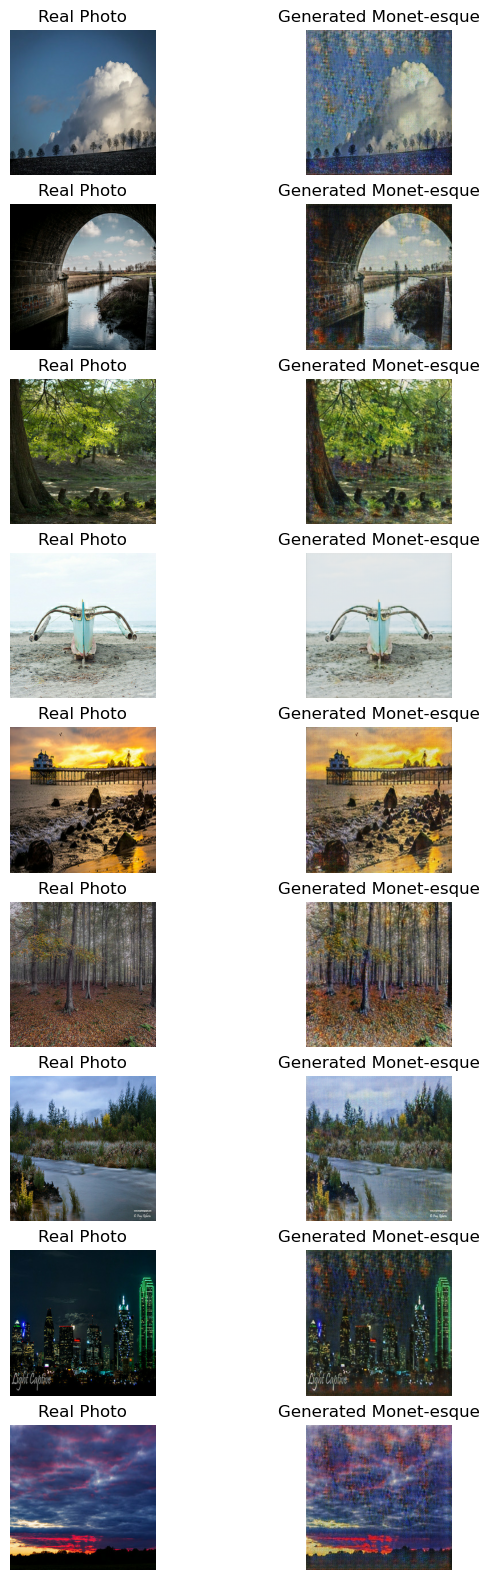

In [155]:
fig,ax= plt.subplots(9,2, figsize=(7,20))
for i,img in enumerate(p_data.take(9)):
    pred= m_gen(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

In [161]:
import PIL

In [162]:
i = 1
for image in p_data:
    pred = m_gen(image, training=False)[0].numpy()
    pred = (pred*127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save("Downloads/Submission Folder/" + str(i) + ".jpg")
    i += 1

In [ ]:
#Commenting this code out because there's no reason to run it locally

#import shutil
#shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Hyperparameters

One major issue with tuning hyperparameters is that this model takes roughly 3 hours to run, so it's very difficult to make iterations and fine tune, but I did decrease the learning rate, increase the number of epochs slightly, and change the beta_1 parameter in the optimizer to try to make noticable improvements. I was only able to run the model twice, so there definitely is room for further improvement, but due to computational restraints this will have to do.

# Conclusion

The model ended up performing fairly well. Some of the images look pretty good, but others do have minor issues. I think one of the major issues I ran into was computing power because I had a very difficult time running the model even once. Overall this project taught me a lot about GAN models and how they can be used, but I do wish I had faster processing speed to more readily make changes and tune hyperparameters.

### References

- https://www.kaggle.com/code/tarndeepsingh16/i-m-something-of-a-painter-myself
- https://www.kaggle.com/code/enzou3/simple-gans-in-monets-paintings
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
- https://www.kaggle.com/code/evrendurmus/my-first-gan-dcgan-with-mnist
- https://keras.io/examples/generative/cyclegan/